<a href="https://colab.research.google.com/github/var-github/Lane-detection/blob/main/Final_lane_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [14]:
import os
import pandas as pd
import numpy as np
import cv2
import tensorflow as tf
from google.colab import files
from tensorflow.keras import layers, models
from google.colab.patches import cv2_imshow
from tensorflow.keras.saving import register_keras_serializable

# TUSimple dataset preprocessing

We are using the TUSimple dataset for lane detection. The dataset is 23GB and needs to be processed before using. The code below only stores the image of every 20 frames in a separate folder - this data is enough to train.

[Dataset link](https://www.kaggle.com/datasets/manideep1108/tusimple)

In [15]:
import kagglehub
path = kagglehub.dataset_download("manideep1108/tusimple")

Using Colab cache for faster access to the 'tusimple' dataset.


In [16]:
IMAGE_FOLDER = "tusimple_processed/images"
LABEL_FOLDER = "tusimple_processed/lane_images"

try:
    os.makedirs(IMAGE_FOLDER)
    os.makedirs(LABEL_FOLDER)
except:
    pass

In [17]:
import shutil
for folder in [path + "/TUSimple/train_set/clips", path + "/TUSimple/test_set/clips"]:
    for clip_dir in os.listdir(folder):
        clip_dir_path = os.path.join(folder, clip_dir)

        # iterate through each sub directory
        for frame_dir in os.listdir(clip_dir_path):
            frame_path = os.path.join(clip_dir_path, frame_dir, "20.jpg")

            # check if file is present
            if not os.path.isfile(frame_path):
                continue

            # create new filename based on last 2 directory names
            new_filename = f"{clip_dir}_{frame_dir}.jpg"
            new_file_path = os.path.join(IMAGE_FOLDER, new_filename)

            shutil.copy(frame_path, new_file_path)


# Coordinates of lanes are stored in these files
df1 = pd.read_json(path + "/TUSimple/train_set/label_data_0313.json", lines = True)
df2 = pd.read_json(path + "/TUSimple/train_set/label_data_0531.json", lines = True)
df3 = pd.read_json(path + "/TUSimple/train_set/label_data_0601.json", lines = True)
df4 = pd.read_json(path + "/TUSimple/test_label.json", lines = True)
df = pd.concat([df1, df2, df3, df4])


for index, row in df.iterrows():
    # Creating black background
    lane_image = np.zeros((720, 1280))
    lanes = row.lanes
    y_coor_of_lane = row.h_samples

    # There can be upto 4 lanes present in the road, each element of 'lanes' has x-coordinates of an entire lane
    for x_coor_of_lane in lanes:
        lane = []
        for coordinates in zip(x_coor_of_lane, y_coor_of_lane):
            if coordinates[0] != -2:
                lane += [coordinates]
        # Draw lane on black background
        cv2.polylines(lane_image, [np.array(lane)], isClosed = False, color = (255, 255, 255), thickness = 15)

    new_filename = "_".join(row.raw_file.split('/')[1:3])+".jpg"
    new_file_path = os.path.join(LABEL_FOLDER, new_filename)

    # store lane images
    cv2.imwrite(new_file_path, lane_image)

# Change path to new folder
path = "tusimple_processed"

# Data visualization

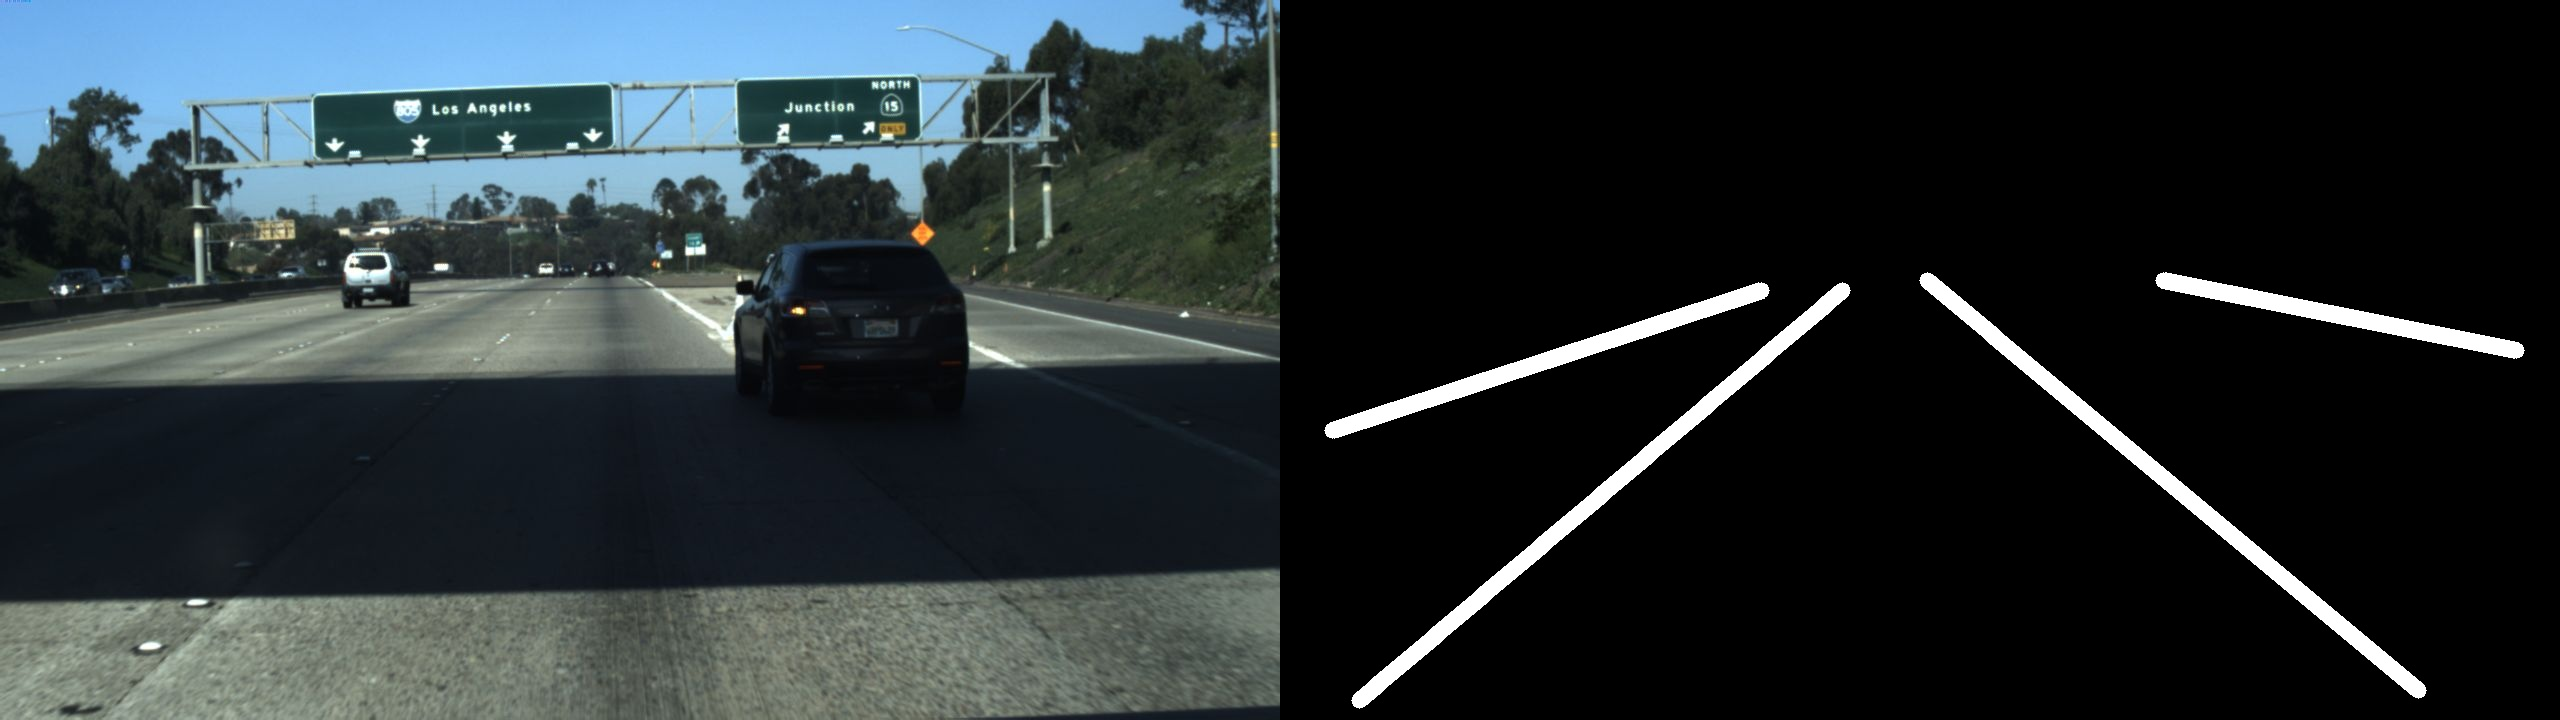

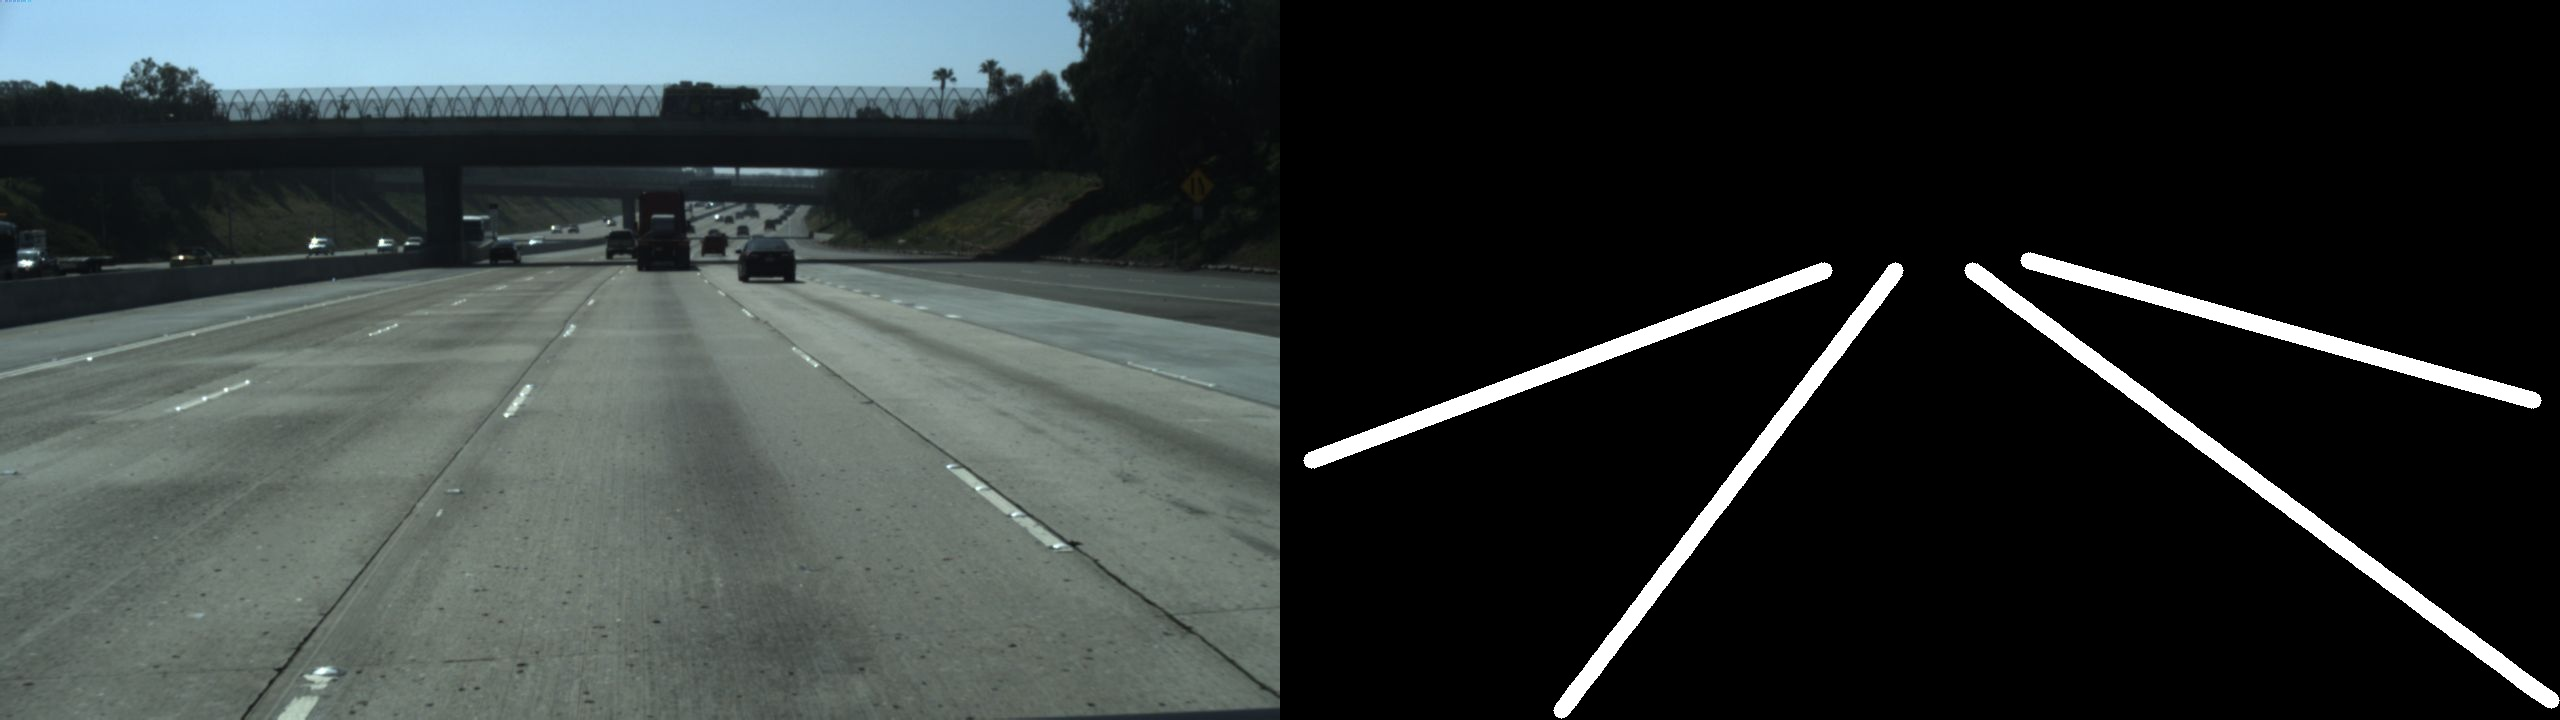

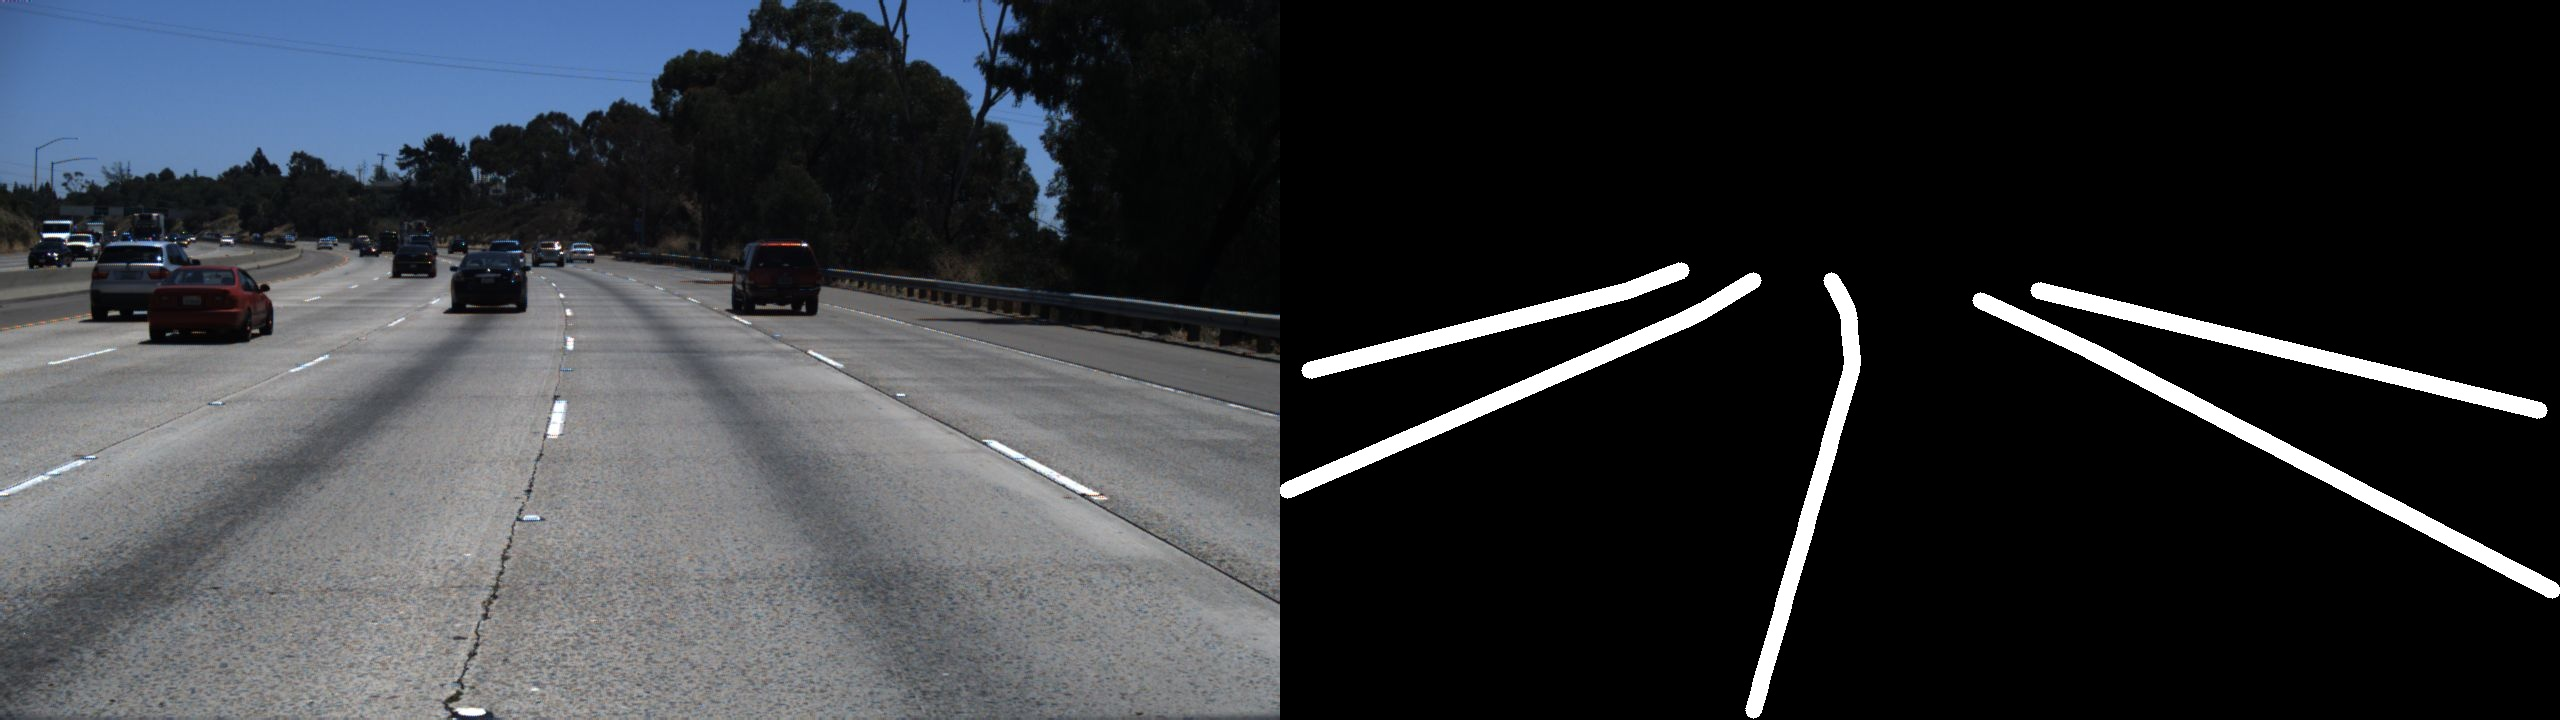

In [18]:
path = "tusimple_processed"
for i in os.listdir(path + "/images")[:3]:
    image = cv2.imread(path + "/images/" + i)
    lane_image = cv2.imread(path + "/lane_images/" + i)
    cv2_imshow(cv2.hconcat([image, lane_image]))

# Model definition and data loading

In [5]:
from sklearn.model_selection import train_test_split
data_filenames = [os.path.join(path + "/images", file) for file in os.listdir(path + "/images")]
mask_filenames = [os.path.join(path + "/lane_images", file) for file in os.listdir(path + "/lane_images")]
x_train, x_test, y_train, y_test = train_test_split(data_filenames, mask_filenames, test_size=0.2, shuffle=False)

In [6]:
def load_image_and_mask(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [360, 640])
    image = image / 255.0
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_jpeg(mask, channels=1)
    mask = tf.image.resize(mask, [360, 640])
    mask = mask / 255.0
    return image, mask

# From tensor slices returns element by element - basically first element of x_train and first element of y_train
# When you use tf.data.AUTOTUNE with functions like .map() or .prefetch(), TensorFlow dynamically decides the optimal number of parallel calls or batches to prepare in the background
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.map(load_image_and_mask)
dataset = dataset.batch(16)

Custom loss function

In [7]:
@register_keras_serializable()
def weighted_bce(y_true, y_pred):
    penality = 20.0
    # y_true = 1 when it is a lane pixel, then w = 50
    # y_true = 0 when it background, then w = 1
    w = y_true * penality + (1 - y_true) * 1.0

    # Compute standard binary cross-entropy
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    # original image shape - [batch, height, width, 1], bce shape = [batch, height, width]
    # Hence adding another dimension
    bce = tf.expand_dims(bce, axis=-1)

    # .reduce_mean takes matrix like this [[0.9, 0.1, 0.8], [0.2, 0.7, 0.3]] and averages all numbers
    # Here we are taking mean of error of each pixel
    return tf.reduce_mean(w * bce)

Attention module

In [8]:
@register_keras_serializable()
class spatial_attention(layers.Layer):
    def __init__(self, **kwargs):
        super(spatial_attention, self).__init__(**kwargs)
        self.conv = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')

    def call(self, inputs):
        avg_pool = tf.reduce_mean(inputs, axis=3, keepdims=True)
        max_pool = tf.reduce_max(inputs, axis=3, keepdims=True)
        concat = tf.concat([avg_pool, max_pool], axis=3)
        attention = self.conv(concat)
        return inputs * attention

    def get_config(self):
        base_config = super(spatial_attention, self).get_config()
        return base_config

Model structure

```
model = models.Sequential([
    layers.Input(shape=(360, 640, 3))
])
```
Not using this because we want to skip connections.

The output of one layer is directly passed ("skipped") to a later layer further down the network, bypassing intermediate layers. Instead of just feeding the output of one layer to the very next layer, skip connections allow the network to add or concatenate the earlier layer's output to the deeper layer's input.

This concatenation helps keep better spatial info

In [ ]:
inputs = layers.Input(shape=(360, 640, 3))

c1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
x = spatial_attention()(c1)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)

c2 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = spatial_attention()(c2)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)

c3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = spatial_attention()(c3)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Dropout(0.2)(x)

u1 = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x)
x = layers.Concatenate()([u1, c3])
x = spatial_attention()(x)

u2 = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
x = layers.Concatenate()([u2, c2])
x = spatial_attention()(x)

u3 = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
x = layers.Concatenate()([u3, c1])
x = spatial_attention()(x)

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(x)

model = models.Model(inputs, outputs)
model.compile(optimizer="adam", loss=weighted_bce, metrics=["accuracy"])
model.save('lane_detection.keras')

# Model training

In [19]:
model = tf.keras.models.load_model('lane_detection_final_6.keras', custom_objects={'weighted_bce': weighted_bce})

In [ ]:
model.fit(dataset, epochs=10)
model.save('lane_detection.keras')
files.download('lane_detection.keras')

Epoch 1/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 320s 862ms/step - accuracy: 0.9261 - loss: 0.2933
Epoch 2/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 259s 789ms/step - accuracy: 0.9269 - loss: 0.2889
Epoch 3/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 263s 792ms/step - accuracy: 0.9273 - loss: 0.2858
Epoch 4/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 262s 793ms/step - accuracy: 0.9276 - loss: 0.2836
Epoch 5/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 262s 793ms/step - accuracy: 0.9276 - loss: 0.2829
Epoch 6/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 262s 793ms/step - accuracy: 0.9276 - loss: 0.2827
Epoch 7/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 262s 792ms/step - accuracy: 0.9281 - loss: 0.2818
Epoch 8/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 262s 793ms/step - accuracy: 0.9283 - loss: 0.2798
Epoch 9/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 262s 794ms/step - accuracy: 0.9280 - loss: 0.2807
Epoch 10/10
321/321 ━━━━━━━━━━━━━━━━━━━━ 262s 793ms/step - accuracy: 0.9283 - loss: 0.2794


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Model testing

In [ ]:
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_set = test_set.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
test_set = test_set.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
loss, accuracy = model.evaluate(test_set)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 480ms/step - accuracy: 0.9444 - loss: 0.3614
Test Loss: 0.3606
Test Accuracy: 0.9448


# Model output

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step


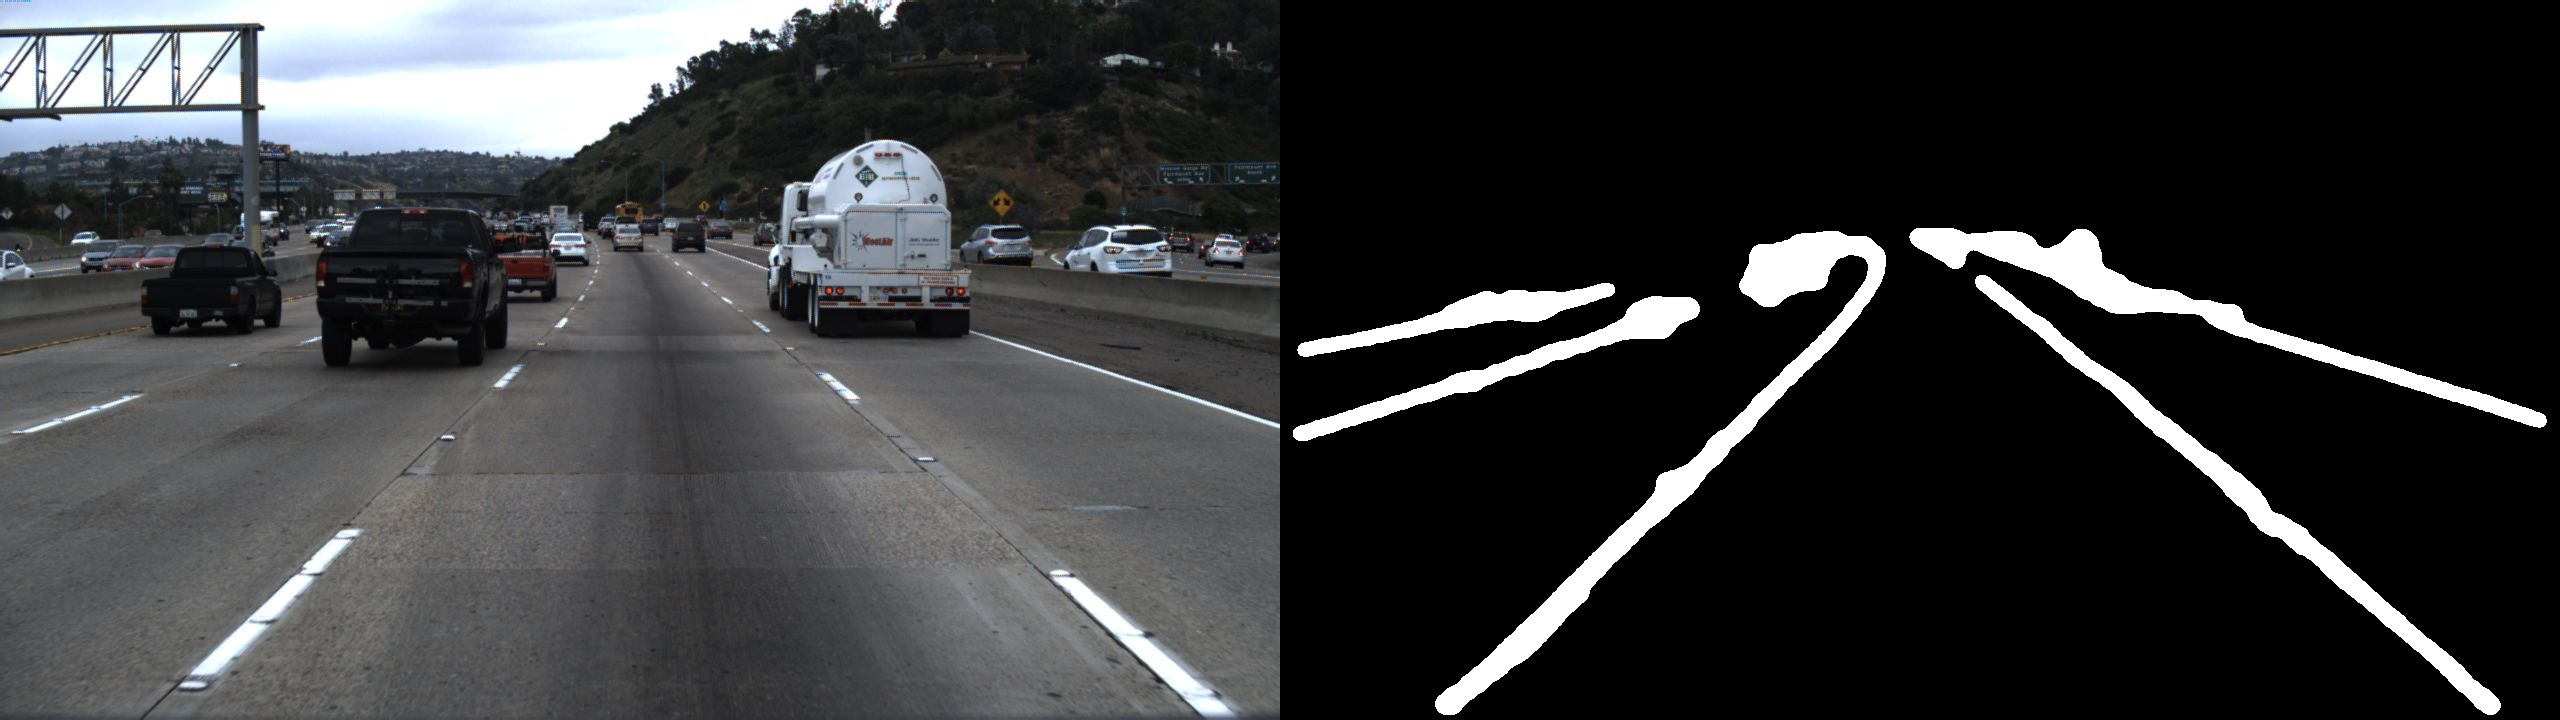

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


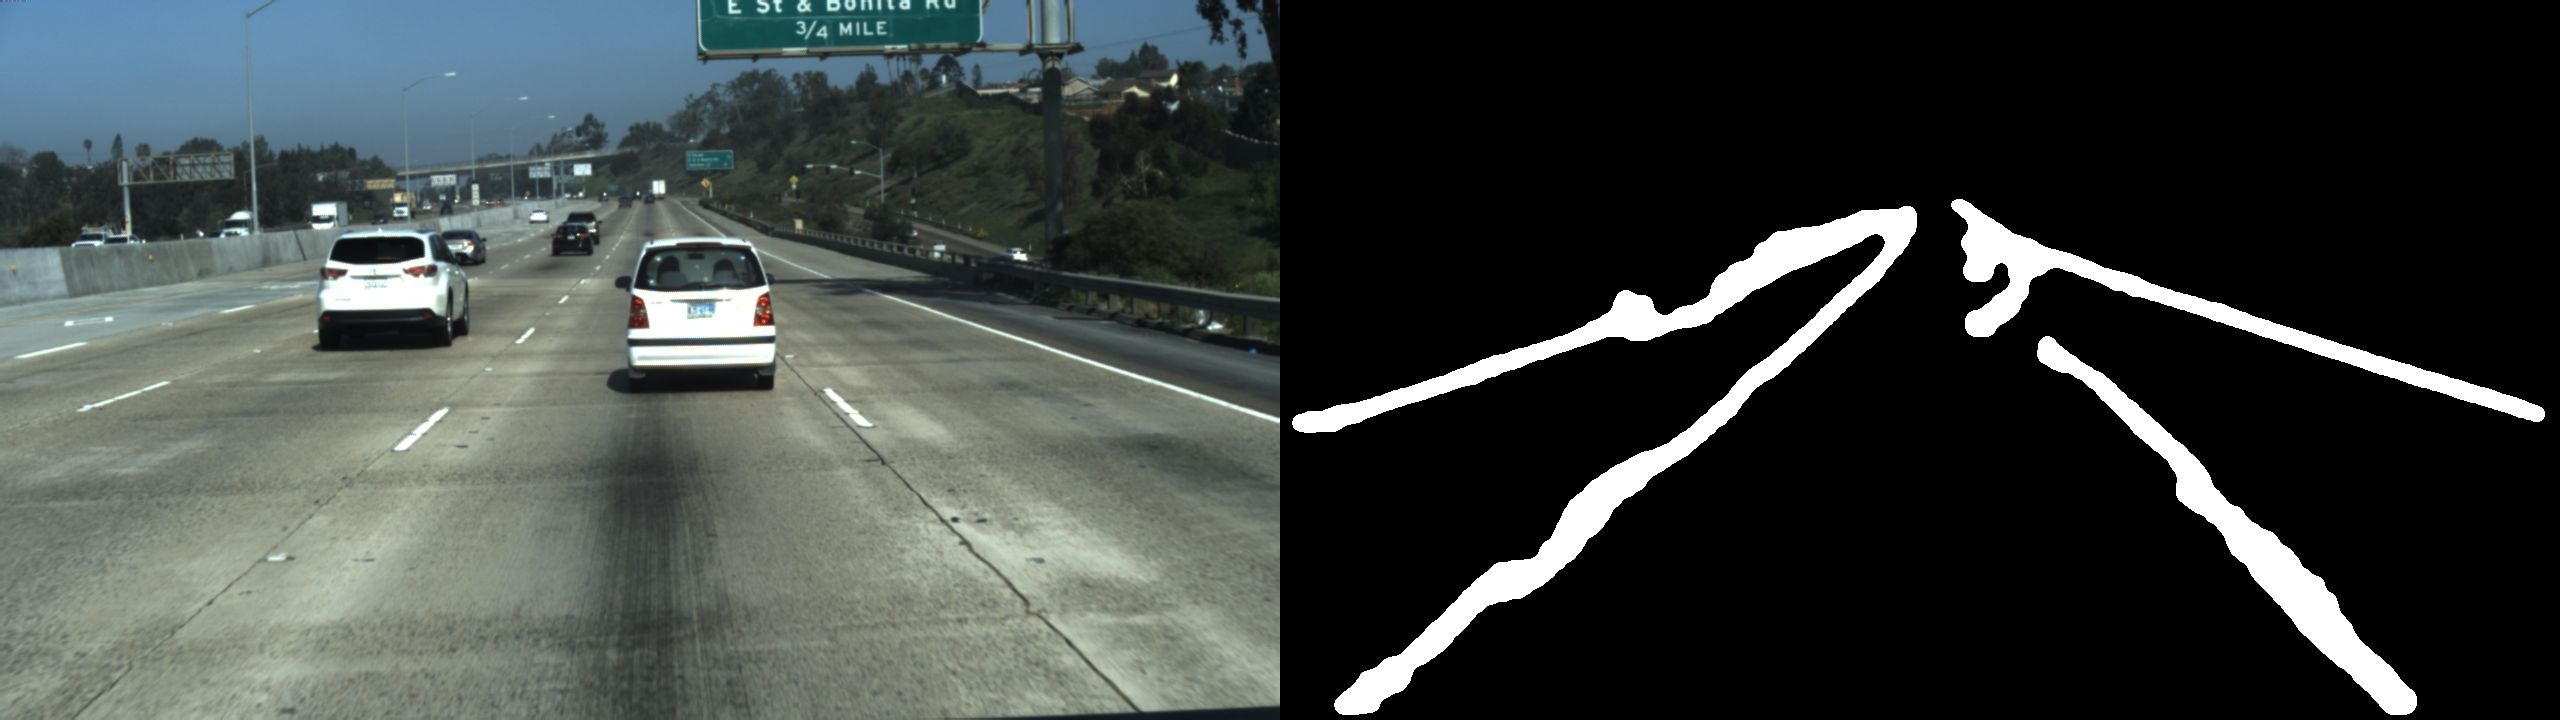

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


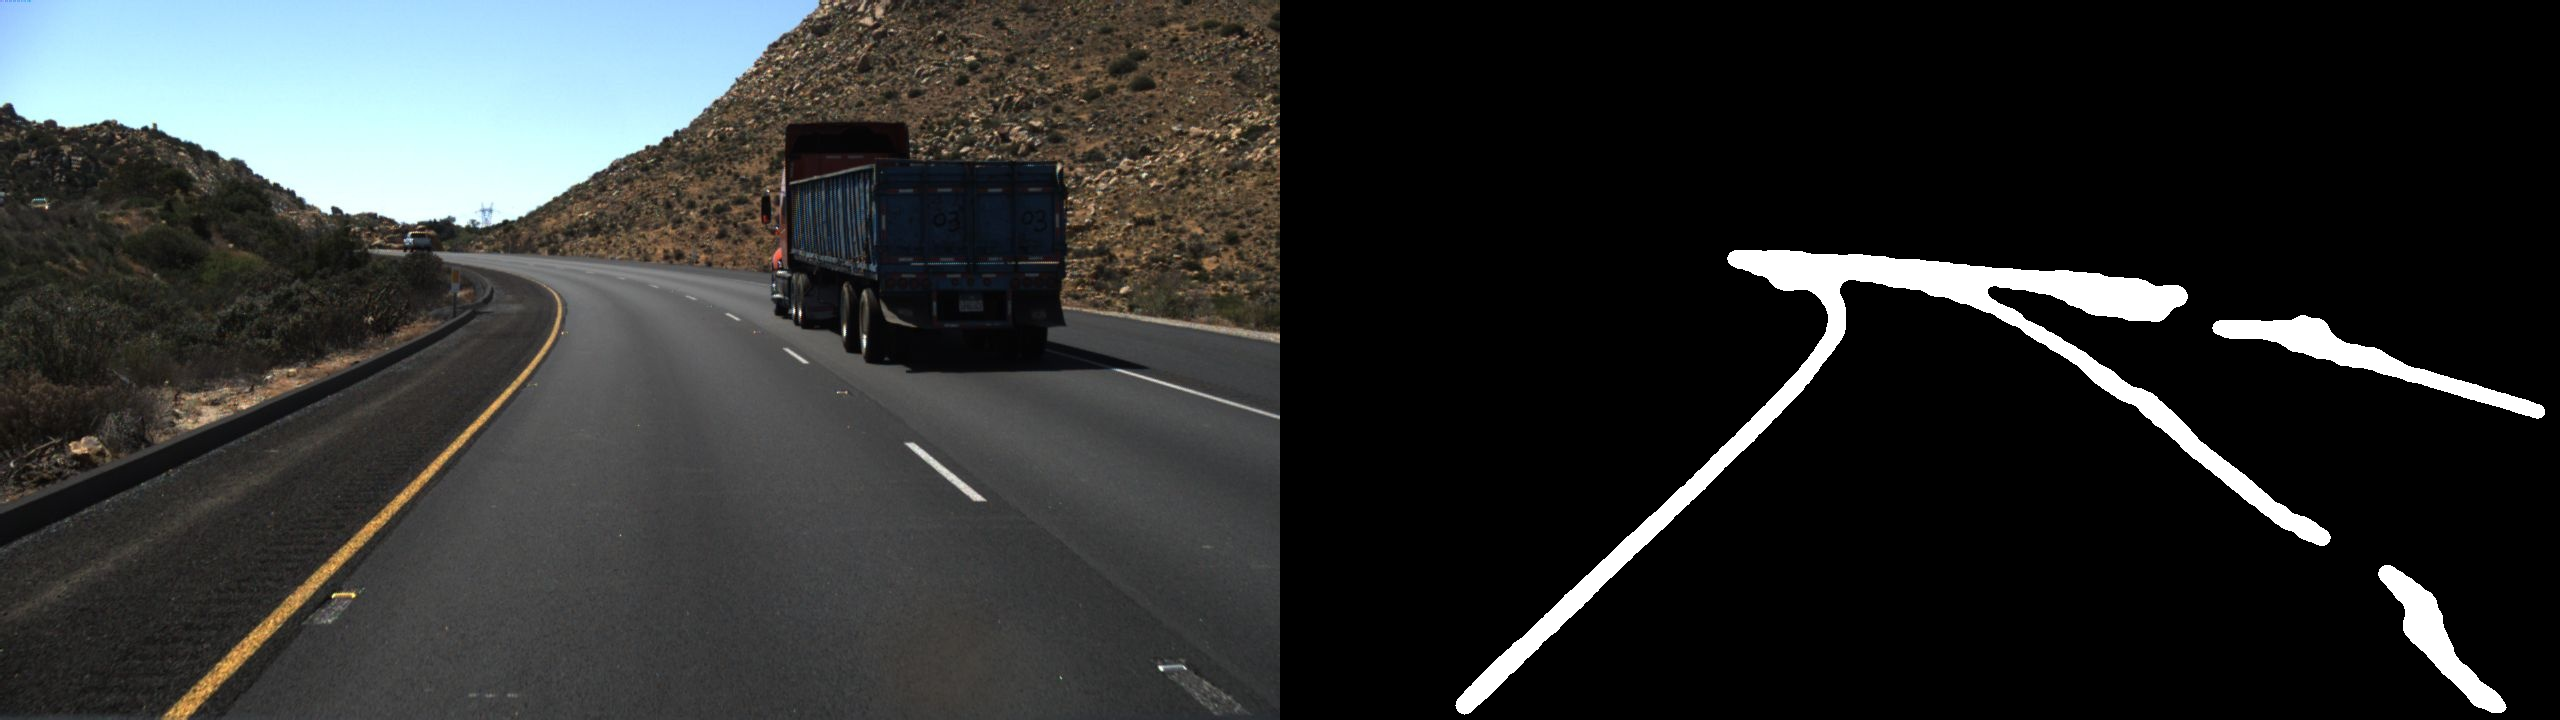

In [12]:
for j in range(3):
    original_img = cv2.imread(x_test[j])
    img_input = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    img_input = cv2.resize(img_input, (640, 360)) / 255.0
    img_input = np.expand_dims(img_input, axis=0)

    pred_mask = model.predict(img_input)               # output shape: (1, 320, 180, 1)
    pred_mask = np.squeeze(pred_mask, axis=0)          # shape: (320, 180, 1)
    pred_mask = np.squeeze(pred_mask, axis=-1)         # shape: (320, 180)

    # Resize predicted mask back to original image size
    pred_mask = cv2.resize(pred_mask, (1280, 720))

    # Threshold to binary mask
    pred_mask = (pred_mask > 0.5).astype(np.uint8) * 255

    # Erode (to make lanes thinner) before blurring
    erode_kernel = np.ones((3, 3), np.uint8)
    pred_mask = cv2.erode(pred_mask, erode_kernel, iterations=2)

    # Morphological open - to remove small dots
    open_kernel = np.ones((11, 11), np.uint8)
    pred_mask = cv2.morphologyEx(pred_mask, cv2.MORPH_OPEN, open_kernel)
    for i in range(20):
        pred_mask = cv2.GaussianBlur(pred_mask, (11, 11), 0)
        _, pred_mask = cv2.threshold(pred_mask, 127, 255, cv2.THRESH_BINARY)

    # Remove blobs smaller than 1500 area
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(pred_mask, connectivity=8)
    pred_mask = np.zeros_like(pred_mask)
    min_area = 1500
    for label in range(1, num_labels):
        if stats[label, cv2.CC_STAT_AREA] >= min_area:
            pred_mask[labels == label] = 255

    # Convert filtered mask to BGR for overlay
    pred_mask = cv2.cvtColor(pred_mask, cv2.COLOR_GRAY2BGR)

    cv2_imshow(cv2.hconcat([original_img, pred_mask]))